In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import preprocessor as p

import string
from string import punctuation

import collections
from collections import Counter

import nltk
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score


import en_core_web_sm
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brajeshkarna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load Tweets

In [2]:
def LoadTweetFile():
    data = pd.read_csv("/Users/brajeshkarna/Documents/FatTalk/combined_tweets_2021.csv")
    return data

tweetDf = LoadTweetFile()

/var/folders/d9/ghy46zzj2454k38j3h7282mr0000gn/T/ipykernel_5482/104894681.py:5: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,15,16,17,18,19,20,21,24,25,26,27) have mixed types.Specify dtype option on import or set low_memory=False.
  tweetDf = LoadTweetFile()


### Select tweets for date range and clean tweets, remove hashtags too from the tweets

In [3]:
tweets_bowl = pd.DataFrame(tweetDf[['user_id', 'tweet','tweet_created_at','user_username','searchquery']])
#removing if there is string on date columns and making index and sorting by the date
tweets_bowl['tweet_created_at'] = pd.to_datetime(tweets_bowl['tweet_created_at'], errors='coerce')
tweets_bowl = tweets_bowl.dropna(subset=['tweet_created_at'])
tweets_bowl = tweets_bowl.set_index(tweets_bowl['tweet_created_at'])
tweets_bowl = tweets_bowl.sort_index()
##Split data based on date
tweets_bowl = tweets_bowl['2021-11-23': '2021-11-26']

In [4]:
def clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df['tweets'] = df[text_field].apply(lambda x: re.sub(r'(@[A-Za-z0–9]+)|([0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?','', x)) 
    return df

tweets_bowl = clean_text(tweets_bowl, 'tweet')

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")
REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?)|(-)|(/)|(:).")

def clean_tweets(df):
  tempArr = []
  for line in df:
    p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.SMILEY, p.OPT.NUMBER,p.OPT.RESERVED)
    tmpL = p.clean(line)
    tmpL = REPLACE_NO_SPACE.sub("", tmpL.lower()) 
    tmpL = REPLACE_WITH_SPACE.sub(" ", tmpL)
    tempArr.append(tmpL)
  return tempArr


tweets_bowl['tweets'] = clean_tweets(tweets_bowl['tweet'])
tweets_bowl['tweets'] = tweets_bowl['tweets'].apply(lambda x: x.replace('#', ''))

### Furnish tweets

In [5]:
nlp = en_core_web_sm.load()
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
w_tokenizer = WhitespaceTokenizer()

def furnished(text):
    final_text = []
    for i in w_tokenizer.tokenize(text):
       if i.lower() not in stop:
           word = lemmatizer.lemmatize(i)
           final_text.append(word.lower())
    return " ".join(final_text)


tweets_bowl.tweets = tweets_bowl.tweets.apply(furnished)

### Dictionary words for domains

In [6]:
fat_related_words = '''Heavy Excess weight Excess fat Overweight Big Weight problem Obese Obesity
Obeast Large Large size Hefty High BMI Fat Fatness heffer Huge Thick Thicc/thiccc Thict thic fit
Thiccums Thickie THICCCCC Thickness Plump plumper Round Unfit Fluffy unhealthy Unhealthy BMI Unhealthy weight
BMI Unhealthy body weight Heaviness Back fat Gaining weight Normal weight Chubby Chubble Chubbin’
Chubblies chubby breasts Chubba Chubby rubby Gordo Morbid obesity Plus size Curvy Full figured
Weight problem Big boned Well endowed Big girl Fat slob Voluptuous Husky Huskaroo Chunky Piernuda leggy referring to thigh size
Nalgona big butt Fat ass FUPA fat upper pubic area FUPA fat upper pussy area Phanny pack same as FUPA Fat fuck
Fat fucking'''

In [7]:
economy_related_words = '''agriculture infrastructure capitalism trading service sector technology  economical supply 
industrialism efficiency frugality retrenchment downsizing   credit debit value 
economize   save  economically
economies sluggish rise   rising spending conserve trend 
low-management  decline   industry impact poor  
profession    surplus   fall
declining  accelerating interest sectors balance stability productivity increase rates
pushing expanding stabilize  rate industrial borrowing struggling
deficit predicted    increasing  data
economizer analysts investment market-based economy   debt free enterprise
medium  exchange metric savepoint scarcity capital bank company stockholder fund business  
asset treasury tourism incomes contraction employment jobs upturn deflation  macroeconomics
bankruptcies exporters hyperinflation dollar entrepreneurship upswing marketplace commerce devaluation 
quicksave deindustrialization stockmarket reflation downspin dollarization withholder bankroll venture capital
mutual fund plan economy mortgage lender unemployment rate credit crunch central bank financial institution
bank rate custom duties mass-production black-market developing-countries developing economic-growth gdp trade barter 
distribution downturn economist'''

In [8]:
social_related_words = '''sociable, gregarious societal friendly society socialization political  sociality 
interpersonal  ethnic socially party welfare public community socialist societies development
network humans socialism collective personal corporation social constructivism
relations volition citizenship brute   attitude rights socio 
socioeconomic ethics civic communal marital  sociale socialized communities     
policy   unions        
institutions values     governmental   organizations jamboree 
festivity    fairness  support  care  
sides   activism     unsocial psychosocial 
socializing psychological distributional  demographic  participation reunion 
partygoer partyism festive power network gala housewarming celebration counterparty   social-war
particularist interactional ideational asocial'''

In [9]:
culture_related_words  = ''' ethnicity heritage modernity spirituality marxismmaterial culture 
ethos nationality humanism romanticism civilisation traditionalism genetics
kinship heredity marriage   indigenous  archeology  acculturate  
ontogenesis viniculture modern clothes     rooted 
cicero societies history roots influence geography historical folk origins 
phenomenon teleology ancient aspects perspective liberalism nowadays community style unique prevalent describes 
today  origin   modernity beliefs  genre barbarian ethnic 
colonization cultural universal organization western-civilization structuralism  culture 
heathen pagan transculturation culture peasant classicist nativism anarchy ungrown philosophic cult  
consciousness islamist bro-culture evolve cultic diaspora aftergrowth native cultural-relativism  
mongolian cosmopolitan epistemology lifestyles diversity chauvinism westernization materialism vernacular 
homogeneity otherness holism tusculanae disputationes primitivism superficiality hedonism discourse
puritanism modernism intellectualism  exclusiveness elitism  colonialism  
pentecostalism paganism nationwide expansion rural  auxesis kimono 
culturize alethophobia nettlebed japanification  dongyi clannishness insularity hybridity
westernisation foreignness worldview exclusionism enculturation ethnocentrism  confucianist vulgarization
shintoism  westernism denominationalism    deracination
eurocentrism  cosmologies  emotiveness bohemianism territorialism
philosophical-doctrine ethnic minority social-darwinism  theory cultural evolution belief systemfolk music 
traditional art house karl-marx   theorymedia  
film-theory art history museum studies cultural artifact'''

In [10]:
health_related_words = '''disease obesity world health organization medicine nutrition well-being exercise welfare wellness health care public health 
nursing stress safety hygiene research social healthy condition aids epidemiology healthiness wellbeing
care illness medical dieteducation infectious disease environmental healthcare physical fitness hospitals 
health care provider doctors healthy community design insurance sanitation human body patient mental health
medicare agriculture health science fitnesshealth policy  weight loss physical therapy psychology pharmacy
metabolic organism human lifestyle status unhealthy upbeat vaccination sleep condom alcohol smoking water family
eudaimonia eudaemonia air house prevention genetics public families poor needs treatment communicable disease 
study protection malaria development food priority management healthful mental provide department administration
programs help assistance funding environment improving emergency need program affected schools private mental illness 
treat diseases preparedness perinatal fertility sickness veterinary sanitary pharmacists behavioral midwives
gerontology infertility hospitalization midwifery cholesterol childcare pediatrician pediatrics medicaid asthma 
pensions sicknesses push-up physical education body-mass-index eat well gymnastic apparatus tune up good morning 
bathing low blood-pressure heart attack health club ride-bike you feel good eczema urticaria dermatitis sunburn overwork 
manufacturing medical sociology need exercise run'''

In [11]:
fat = furnished(fat_related_words.lower())
economy = furnished(economy_related_words)
social = furnished(social_related_words)
cultural = furnished(culture_related_words)
health = furnished(health_related_words)

In [12]:
string1 = fat
words = string1.split()
fat = " ".join(sorted(set(words), key=words.index))
fat

string2 = economy
words = string2.split()
economy = " ".join(sorted(set(words), key=words.index))
economy

string3 = social
words = string3.split()
social = " ".join(sorted(set(words), key=words.index))
social

string4 = cultural
words = string4.split()
cultural = " ".join(sorted(set(words), key=words.index))
cultural

string5 = health
words = string5.split()
health = " ".join(sorted(set(words), key=words.index))
health

'disease obesity world health organization medicine nutrition well-being exercise welfare wellness care public nursing stress safety hygiene research social healthy condition aid epidemiology healthiness wellbeing illness medical dieteducation infectious environmental healthcare physical fitness hospital provider doctor community design insurance sanitation human body patient mental medicare agriculture science fitnesshealth policy weight loss therapy psychology pharmacy metabolic organism lifestyle status unhealthy upbeat vaccination sleep condom alcohol smoking water family eudaimonia eudaemonia air house prevention genetics poor need treatment communicable study protection malaria development food priority management healthful provide department administration program help assistance funding environment improving emergency affected school private treat preparedness perinatal fertility sickness veterinary sanitary pharmacist behavioral midwife gerontology infertility hospitalization 

### Jaccard Similarity Scores

In [13]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)

def get_scores(group,tweets):
    scores = []
    for tweet in tweets:
        s = jaccard_similarity(group, tweet)
        scores.append(s)
    return scores

f_scores = get_scores(fat, tweets_bowl.tweets.to_list())
e_scores = get_scores(economy, tweets_bowl.tweets.to_list())
s_scores = get_scores(social, tweets_bowl.tweets.to_list())
c_scores = get_scores(cultural, tweets_bowl.tweets.to_list())
h_scores = get_scores(health, tweets_bowl.tweets.to_list())


# create a jaccard scored df.
data  = {'names':tweets_bowl.user_username.to_list(),'fat_score': f_scores,'economic_score':e_scores,'social_score':s_scores,'cultural_score':c_scores,'health_score':h_scores}

scores_df = pd.DataFrame(data)

In [14]:
def get_classes(l1, l2,l3,l4,l5):
    fat1 = []
    economy1 = []
    social1 = []
    cultural1 = []
    health1 =[]
    
    for i, j,k,l,n in zip(l1, l2,l3,l4,l5):
        m = max(i, j)
        if m == i:
            fat1.append(1)
        else:
            fat1.append(0) 
        if m == j:
            economy1.append(1)
        else:
            economy1.append(0)
        if m == k:
            social1.append(1)
        else:
            social1.append(0)   
        if m == l:
            cultural1.append(1)
        else:
            cultural1.append(0)   
        if m == n:
            health1.append(1)
        else:
            health1.append(0) 
            
    return fat1,economy1,social1,cultural1,health1

l1 = scores_df.fat_score.to_list()
l2 = scores_df.economic_score.to_list()
l3 = scores_df.social_score.to_list()
l4 = scores_df.cultural_score.to_list()
l5 = scores_df.health_score.to_list()


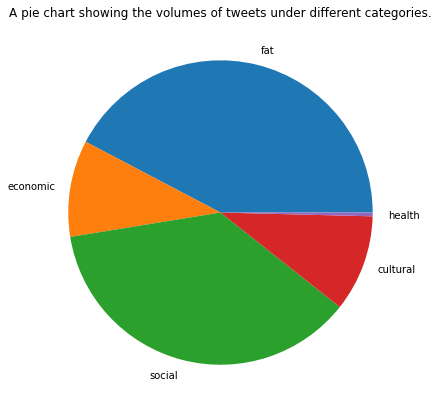

In [15]:
fat1, economy1, social1, cultural1, health1 = get_classes(l1, l2,l3,l4,l5)
data = {'name': scores_df.names.to_list(), 'fat':fat1, 'economic':economy1,'social':social1,'cultural':cultural1, 'health':health1}
class_df = pd.DataFrame(data)
#grouping the tweets by username
new_groups_df = class_df.groupby(['name']).sum()
#add a new totals column
new_groups_df['total'] = new_groups_df['fat'] + new_groups_df['economic'] + new_groups_df['social']+ new_groups_df['cultural'] + new_groups_df['health'] 
#add a new totals row
new_groups_df.loc["Total"] = new_groups_df.sum()  

fig = plt.figure(figsize =(10, 7)) 
a = new_groups_df.drop(['total'], axis = 1)
plt.pie(a.loc['Total'], labels = a.columns)
plt.title('A pie chart showing the volumes of tweets under different categories.')
plt.show()


In [16]:
fat1, economy1, social1, cultural1, health1 = get_classes(l1, l2,l3,l4,l5)
data = {'name': scores_df.names.to_list(), 'fat':fat1, 'economic':economy1,'social':social1,'cultural':cultural1, 'health':health1}
class_df = pd.DataFrame(data)
#grouping the tweets by username
new_groups_df = class_df.groupby(['name']).sum()

In [17]:
new_groups_df.head()


,fat,economic,social,cultural,health
name,,,,,
0000seapea808,1,0,1,0,0
0007Tiara,1,0,1,0,0
000Tension,1,0,1,0,0
000_Rhiz,1,0,0,0,0
000skinni,2,0,1,0,0


In [18]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage


X = np.array(new_groups_df.iloc[:,[0,1,2,3,4]].values)

In [19]:
model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
model.fit(X)
labels = model.labels_

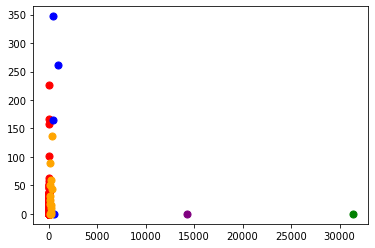

In [20]:
plt.scatter(X[labels==0, 0], X[labels==0, 1], s=50, marker='o', color='red')
plt.scatter(X[labels==1, 0], X[labels==1, 1], s=50, marker='o', color='blue')
plt.scatter(X[labels==2, 0], X[labels==2, 1], s=50, marker='o', color='green')
plt.scatter(X[labels==3, 0], X[labels==3, 1], s=50, marker='o', color='purple')
plt.scatter(X[labels==4, 0], X[labels==4, 1], s=50, marker='o', color='orange')
plt.show()